In [1]:
%%configure
{"vCores": 16}

Minor Modification from https://github.com/microsoft/fabric-toolbox/tree/main/tools/FabricLoadTestTool

In [2]:
!pip install -q            --disable-pip-version-check semantic-link-labs
!pip install -q duckdb     --upgrade
!pip install -q deltalake  --upgrade
!pip install -q pandas     --upgrade
notebookutils.session.restartPython()

sys.exit called with value 0. The interpreter will be restarted.


In [3]:
import sempy_labs as labs
try:
    labs.import_notebook_from_web(overwrite=False,notebook_name="process_data"       , url="https://raw.githubusercontent.com/djouallah/fabric_demo/refs/heads/main/process_data.ipynb")
    labs.import_notebook_from_web(overwrite=False,notebook_name="RunPerfScenario"    , url="https://raw.githubusercontent.com/djouallah/fabric_demo/refs/heads/main/Benchmark/RunPerfScenario.ipynb")
except Exception as e:
    print(f"Error: {e}")

Error: 🔴 The 'process_data' already exists within the 'temp' workspace and 'overwrite' is set to False.


In [4]:
from   deltalake        import DeltaTable
from   deltalake.writer import write_deltalake
import time 
import duckdb
import os
import matplotlib.pyplot as plt
from   psutil import *
core              = cpu_count()
from notebookutils.common import configs
configs.tokenCacheEnabled = False
print(core)

16


In [5]:
try:
    duckdb.sql(" force install delta from core_nightly;")
    duckdb.sql("update extensions").show()
except:
    pass

┌────────────────┬──────────────┬─────────────────────┬──────────────────┬─────────────────┐
│ extension_name │  repository  │    update_result    │ previous_version │ current_version │
│    varchar     │   varchar    │       varchar       │     varchar      │     varchar     │
├────────────────┼──────────────┼─────────────────────┼──────────────────┼─────────────────┤
│ azure          │ core         │ NO_UPDATE_AVAILABLE │ 5e458fc          │ 5e458fc         │
│ delta          │ core_nightly │ NO_UPDATE_AVAILABLE │ 03aaf0f          │ 03aaf0f         │
└────────────────┴──────────────┴─────────────────────┴──────────────────┴─────────────────┘



**<mark>Update Data</mark>**

In [6]:
lh                    = 'power' 
schema                = 'aemo'
semantic_model        = "directlake_on_onelake" 
nbr_days_download     =  2800
ws                    =  notebookutils.runtime.context.get("currentWorkspaceName")

In [7]:
totalrows = notebookutils.notebook.run("process_data",7200,{"semantic_model": semantic_model,"lh":lh ,"schema":schema,"nbr_days_download":nbr_days_download,"Nbr_threads": core*2})

In [8]:
load_test_name     = "loadtest"                                                                                           
queryfile          = "https://raw.githubusercontent.com/djouallah/fabric_demo/refs/heads/main/Benchmark/PowerBIPerformanceData.json"    
concurrent_threads = core                                                                      
delay_sec          = 4                                                                               
iterations         = 1    
cache              = 1   
delta_path         = f"abfss://{ws}@onelake.dfs.fabric.microsoft.com/{lh}.Lakehouse/Tables/dbo/results"                                                                    

In [9]:
def run_test(workspace,dataset):
    if 'Collapse Here':
        ts=time.strftime("%Y%m%d-%H%M%S")
        loadtestId:str = f"{load_test_name}-{ts}"
        print(loadtestId)
        users = []
        args = { 
            "xmla_endpoint" : f"powerbi://api.powerbi.com/v1.0/myorg/{workspace}", #defaults to current workspace's endpoint
            "perf_analyzer_filename" : queryfile , 
            "model" : dataset,
            "roles" : None,
            "customdata" : None,
            "effective_username" : None,
            "iterations" : iterations,
            "delay_sec" : 1,
            "loadtestId" : loadtestId ,
            "threadId" : 0 ,
            "concurrent_threads" : concurrent_threads,
            "useRootDefaultLakehouse": True ,
            "cache" : cache ,
            "delta_path" : delta_path,
            "totalrows"  : totalrows
        }

        activity =  {
                    "name": "RunPerfScenario", # activity name, must be unique
                    "path": "RunPerfScenario", # notebook path
                    "timeoutPerCellInSeconds": 90000, # max timeout for each cell, default to 90 seconds
                    "args": {"param1": "value1"}, # notebook parameters
                    "workspace": None, # workspace name, default to current workspace
                    "retry": 0, # max retry times, default to 0
                    "retryIntervalInSeconds": 0, # retry interval, default to 0 seconds
                    "dependencies": [] # list of activity names that this activity depends on
                }


        DAG = {
            "activities": [],
            "timeoutInSeconds": 43200, # max timeout for the entire pipeline, default to 12 hours
            "concurrency": 25 # max number of notebooks to run concurrently, default to 25
        }
        DAG["concurrency"] = concurrent_threads

        for i in range(concurrent_threads):
            a = activity.copy()
            a["name"] = f"{a['name']}_{i}"
            this_args = args.copy()
            if (len(users)>0):
                user = users[i%len(users)]
                this_args["effective_username"] = user 
            this_args["threadId"] = i
            a["args"] = this_args
            DAG["activities"].append(a)
        print('running load test')
        try:
            results = notebookutils.notebook.runMultiple(DAG) 
        except Exception as e:
            first_result = results[list(e.result)[0]]
            print('Notebook failed.  First Result Exception: ')
            print(first_result.get('exception',None))
        print('load test complete')

In [10]:
for workspace, dataset in [(ws,semantic_model)] :
    try:
        run_test(workspace,dataset)
    except Exception as e:
       print(f"Error: {e}")

loadtest-20251002-134150
running load test


In [11]:
dt = DeltaTable(delta_path)
dt.optimize.compact()

{'numFilesAdded': 1,
 'numFilesRemoved': 17,
 'filesAdded': '{"avg":49360.0,"max":49360,"min":49360,"totalFiles":1,"totalSize":49360}',
 'filesRemoved': '{"avg":8165.058823529412,"max":40929,"min":6112,"totalFiles":17,"totalSize":138806}',
 'partitionsOptimized': 1,
 'numBatches': 19,
 'totalConsideredFiles': 17,
 'totalFilesSkipped': 0,
 'preserveInsertionOrder': True}

In [12]:
duckdb.sql(f""" 
                CREATE or replace persistent SECRET onelake ( TYPE AZURE, PROVIDER ACCESS_TOKEN, ACCESS_TOKEN '{notebookutils.credentials.getToken('storage')}') ;
                create or replace table raw
                as select
                *exclude(model),
                case when model ='directquery' then 'dwh'  else model end as Engine ,
                from delta_scan('{delta_path}')
                where
                cache = 1
                and concurrent_threads = {concurrent_threads}
                and iterations = 1
                and start_time_dt > '2025-09-17 10:00:00'              
 """)

In [13]:
summary = duckdb.sql(""" 
         select
         Engine ,
         concurrent_threads ,
         totalrows ,
         round(avg(duration),2) as avg ,
         round(max(duration),2) as max ,
         round(QUANTILE_CONT(duration, 0.90),2) AS p90_value,
         round(QUANTILE_CONT(duration, 0.99),2) AS p99_value,
         round(geomean(duration),2) AS geomean
 from raw 
       group by all
       order by geomean asc
        """)
summary.show()

┌───────────────────────┬────────────────────┬───────────┬────────┬────────┬───────────┬───────────┬─────────┐
│        Engine         │ concurrent_threads │ totalrows │  avg   │  max   │ p90_value │ p99_value │ geomean │
│        varchar        │       int64        │  varchar  │ double │ double │  double   │  double   │ double  │
├───────────────────────┼────────────────────┼───────────┼────────┼────────┼───────────┼───────────┼─────────┤
│ directlake_on_onelake │                 16 │ 128217307 │   0.08 │   0.61 │      0.13 │      0.38 │    0.07 │
│ directlake_on_onelake │                 16 │ 128218183 │   0.12 │   1.42 │      0.18 │      1.19 │    0.09 │
│ directlake_on_onelake │                 16 │ 128215090 │   0.26 │   6.92 │      0.36 │      5.25 │     0.1 │
└───────────────────────┴────────────────────┴───────────┴────────┴────────┴───────────┴───────────┴─────────┘



In [14]:
summaryhour = duckdb.sql("""
    SELECT
          Engine ,
          strftime(DATE_TRUNC('minute', start_time_dt + INTERVAL '10 hours'), '%Y-%m-%d %H%M') AS minute, 
          concurrent_threads ,
          totalrows ,
          COUNT(*) AS count,
          ROUND(MAX(duration), 3) AS max,
          ROUND(MIN(duration), 3) AS min,
          round(QUANTILE_CONT(duration , 0.90),2) AS p90_value,
          round(QUANTILE_CONT(duration , 0.99),2) AS p99_value,
          round(QUANTILE_CONT(duration , 0.95),2) AS p95_value,
          round(geomean(duration),2) AS geomean
      FROM raw
      GROUP BY all
      ORDER BY minute DESC
""")
summaryhour.show(max_width=190)

┌───────────────────────┬─────────────────┬────────────────────┬───────────┬────────┬────────┬───────┬───────────┬───────────┬───────────┬─────────┐
│        Engine         │     minute      │ concurrent_threads │ totalrows │  max   │  min   │ count │ p90_value │ p99_value │ p95_value │ geomean │
│        varchar        │     varchar     │       int64        │  varchar  │ double │ double │ int64 │  double   │  double   │  double   │ double  │
├───────────────────────┼─────────────────┼────────────────────┼───────────┼────────┼────────┼───────┼───────────┼───────────┼───────────┼─────────┤
│ directlake_on_onelake │ 2025-10-02 2343 │                 16 │ 128218183 │  0.498 │  0.035 │   288 │      0.16 │      0.48 │       0.3 │    0.08 │
│ directlake_on_onelake │ 2025-10-02 2342 │                 16 │ 128218183 │  1.416 │  0.035 │   304 │      0.21 │      1.39 │      0.39 │    0.09 │
│ directlake_on_onelake │ 2025-10-02 2323 │                 16 │ 128217307 │  0.412 │  0.034 │   592 │    

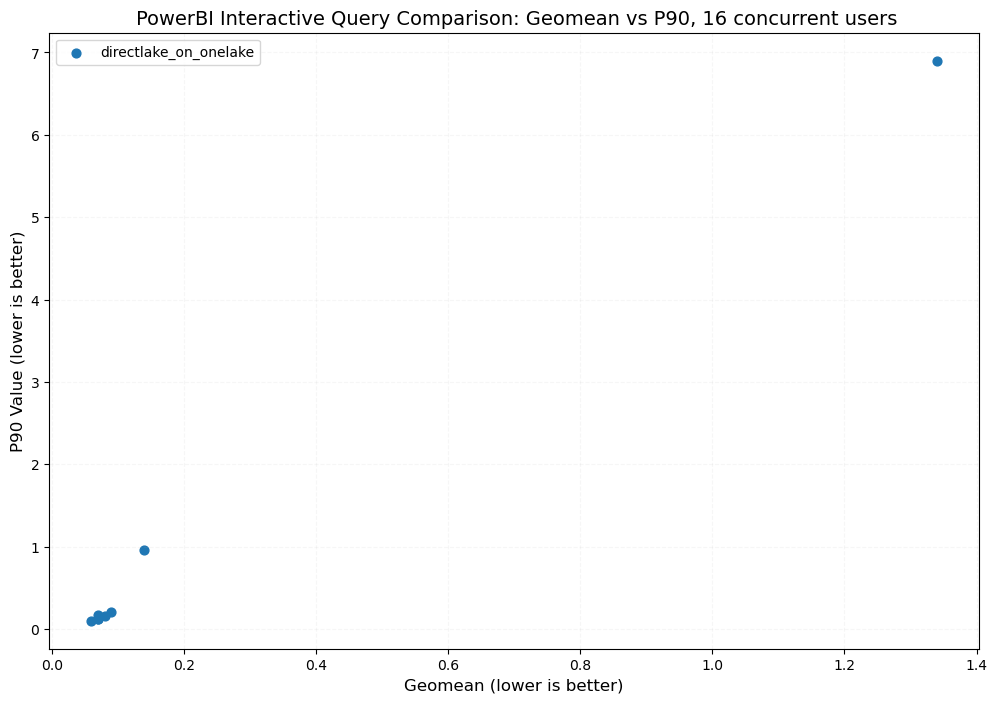

In [15]:
df = duckdb.sql(" select Engine, p90_value,geomean from summaryhour ").df()

plt.figure(figsize=(12,8 ))
for model, group in df.groupby("Engine"):
    plt.scatter(group["geomean"], group["p90_value"], label=model, s=40)

plt.xlabel("Geomean (lower is better)", fontsize=12)
plt.ylabel("P90 Value (lower is better)", fontsize=12)
plt.title(f" PowerBI Interactive Query Comparison: Geomean vs P90, {concurrent_threads} concurrent users", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.1)
plt.show()